## Setup


If you are running this generator locally(i.e. in a jupyter notebook in conda, just make sure you installed:
- RDKit
- DeepChem 2.5.0 & above
- Tensorflow 2.4.0 & above

Then, please skip the following part and continue from `Data Preparations`.

To increase efficiency, we recommend running this molecule generator in Colab.

Then, we'll first need to run the following lines of code, these will download conda with the deepchem environment in colab.

In [1]:
#!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
#import conda_installer
#conda_installer.install()
#!/root/miniconda/bin/conda info -e

In [2]:
#!pip install --pre deepchem
#import deepchem
#deepchem.__version__

## Data Preparations

Now we are ready to import some useful functions/packages, along with our model.

### Import Data

In [3]:
import model##our model

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import deepchem as dc 

Then, we are ready to import our dataset for training. 

Here, for demonstration, we'll be using this dataset of in-vitro assay that detects inhibition of SARS-CoV 3CL protease via fluorescence.

The dataset is originally from [PubChem AID1706](https://pubchem.ncbi.nlm.nih.gov/bioassay/1706), previously handled by [JClinic AIcure](https://www.aicures.mit.edu/) team at MIT into this [binarized label form](https://github.com/yangkevin2/coronavirus_data/blob/master/data/AID1706_binarized_sars.csv).

In [7]:
df = pd.read_csv('AID1706_binarized_sars.csv')

In [8]:
df.head()

,smiles,activity
0,CC1=CC=C(O1)C(C(=O)NCC2=CC=CO2)N(C3=CC=C(C=C3)...,1
1,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)S(=O)(=O)C3=C...,1
2,CC1=CC2=C(C=C1)NC(=O)C(=C2)CN(CCC3=CC=CC=C3)CC...,1
3,CC1=CC=C(C=C1)CN(C(C2=CC=CS2)C(=O)NCC3=CC=CO3)...,1
4,CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C,1


In [9]:
df.groupby('activity').count()

,smiles
activity,
0,290321
1,405


Observe the data above, it contains a 'smiles' column, which stands for the smiles representation of the molecules. There is also an 'activity' column, in which it is the label specifying whether that molecule is considered as hit for the protein.

Here, we only need those 405 molecules considered as hits, and we'll be extracting features from them to generate new molecules that may as well be hits.

In [10]:
true = df[df['activity']==1]

### Set Minimum Length for molecules

Since we'll be using graphic neural network, it might be more helpful and efficient if our graph data are of the same size, thus, we'll eliminate the molecules from the training set that are shorter(i.e. lacking enough atoms) than our desired minimum size.

In [11]:
num_atoms = 6 #here the minimum length of molecules is 6

In [12]:
input_df = true['smiles']
df_length = []
for _ in input_df:
    df_length.append(Chem.MolFromSmiles(_).GetNumAtoms() )

In [13]:
true['length'] = df_length #create a new column containing each molecule's length

/Users/feishu/opt/anaconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
true = true[true['length']>num_atoms] #Here we leave only the ones longer than 6
input_df = true['smiles']
input_df_smiles = input_df.apply(Chem.MolFromSmiles) #convert the smiles representations into rdkit molecules


Now, we are ready to apply the `featurizer` function to our molecules to convert them into graphs with nodes and edges for training.

In [15]:
#input_df = input_df.apply(Chem.MolFromSmiles) 
train_set = input_df_smiles.apply( lambda x: model.featurizer(x,max_length = num_atoms))

In [16]:
train_set

0      ([6, 6, 6, 6, 6, 8], [[0, 2, 0, 0, 0, 0], [2, ...
1      ([6, 6, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
2      ([6, 6, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
3      ([6, 6, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
4      ([6, 6, 7, 6, 7, 6], [[0, 2, 0, 0, 0, 0], [2, ...
                             ...                        
400    ([6, 6, 8, 6, 6, 8], [[0, 2, 0, 0, 0, 2], [2, ...
401    ([6, 8, 6, 8, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
402    ([6, 8, 6, 6, 6, 6], [[0, 2, 0, 0, 0, 0], [2, ...
403    ([6, 7, 6, 6, 6, 7], [[0, 2, 0, 0, 0, 0], [2, ...
404    ([6, 6, 8, 6, 7, 16], [[0, 2, 0, 0, 2, 0], [2,...
Name: smiles, Length: 405, dtype: object

In [17]:
nodes_train, edges_train = list(zip(*train_set) )

## Training

Now, we're finally ready for generating new molecules. We'll first import some necessay functions from tensorflow.

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

The network here we'll be using is Generative Adversarial Network, as mentioned in the project introduction. Here's a great [introduction](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/). 

![Screen Shot 2021-06-08 at 7 40 49 PM](https://user-images.githubusercontent.com/67823308/121178738-709bbd80-c891-11eb-91dc-d45e69f8f4d5.png)


Here we'll first initiate a discriminator and a generator model with the corresponding functions in the package.

In [19]:
disc = model.make_discriminator(num_atoms)

In [20]:
gene = model.make_generator(num_atoms, noise_input_shape = 100)

Then, with the `train_on_batch` function, we'll supply the necessary inputs and train our network. Upon some experimentations, an epoch of around 160 would be nice for this dataset.

>0, d1=0.230, d2=0.759 g=0.565, a1=100, a2=0
>1, d1=0.096, d2=0.841 g=0.622, a1=100, a2=0
>2, d1=0.038, d2=0.890 g=0.594, a1=100, a2=0
>3, d1=0.018, d2=0.915 g=0.564, a1=100, a2=0
>4, d1=0.013, d2=0.853 g=0.515, a1=100, a2=0
>5, d1=0.006, d2=0.837 g=0.579, a1=100, a2=0
>6, d1=0.003, d2=0.876 g=0.540, a1=100, a2=0
>7, d1=0.012, d2=0.868 g=0.577, a1=100, a2=0
>8, d1=0.006, d2=0.868 g=0.571, a1=100, a2=0
>9, d1=0.005, d2=0.879 g=0.610, a1=100, a2=0
>10, d1=0.005, d2=0.842 g=0.658, a1=100, a2=0
>11, d1=0.006, d2=0.722 g=0.687, a1=100, a2=0
>12, d1=0.007, d2=0.777 g=0.758, a1=100, a2=0
>13, d1=0.003, d2=0.607 g=0.836, a1=100, a2=100
>14, d1=0.003, d2=0.578 g=0.850, a1=100, a2=100
>15, d1=0.003, d2=0.532 g=0.952, a1=100, a2=100
>16, d1=0.020, d2=0.482 g=0.965, a1=100, a2=100
>17, d1=0.006, d2=0.459 g=1.054, a1=100, a2=100
>18, d1=0.003, d2=0.411 g=1.121, a1=100, a2=100
>19, d1=0.003, d2=0.380 g=1.147, a1=100, a2=100
>20, d1=0.003, d2=0.424 g=1.160, a1=100, a2=100
>21, d1=0.002, d2=0.359 g=1.

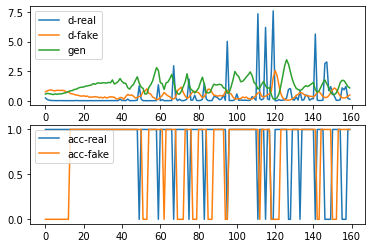

In [21]:
generator_trained = model.train_batch(
                                disc, gene, 
                                np.array(nodes_train), np.array(edges_train), 
                                noise_input_shape = 100, EPOCH = 160, BATCHSIZE = 2, 
                                plot_hist = True, temp_result = False
    )

There are two possible kind of failures regarding a GAN model: model collapse and failure of convergence. Model collapse would often mean that the generative part of the model wouldn't be able to generate diverse outcomes. Failure of convergence between the generative and the discriminative model could likely way be identified as that the loss for the discriminator has gone to zero or close to zero. 

Observe the above generated plot, in the upper plot, the loss of discriminator has not gone to zero/close to zero, indicating that the model has possibily find a balance between the generator and the discriminator. In the lower plot, the accuracy is fluctuating between 1 and 0, indicating possible variability within the data generated. 

Therefore, it is reasonable to conclude that within the possible range of epoch and other parameters, the model has successfully avoided the two common types of failures associated with GAN.

## Rewarding Phase

The above `train_on_batch` function is set to return a trained generator. Thus, we could use that function directly and observe the possible molecules we could get from that function.

In [22]:
no, ed = generator_trained(np.random.randint(0,30, size =(1,100)))#generated nodes and edges

In [23]:
abs(no.numpy()).astype(int).reshape(num_atoms), abs(ed.numpy()).astype(int).reshape(num_atoms,num_atoms)

(array([3, 7, 5, 5, 6, 7]),
 array([[1, 2, 0, 0, 0, 1],
        [1, 0, 2, 1, 1, 0],
        [0, 3, 0, 2, 0, 0],
        [0, 0, 4, 1, 2, 0],
        [0, 0, 1, 3, 0, 3],
        [1, 0, 0, 0, 3, 1]]))

With the `de_featurizer`, we could convert the generated matrix into a smiles molecule and plot it out=)

In [ ]:
cat, dog = model.de_featurizer(abs(no.numpy()).astype(int).reshape(num_atoms), abs(ed.numpy()).astype(int).reshape(num_atoms,num_atoms))

In [26]:
Chem.MolToSmiles(cat)

'[Li]NBBC=N'

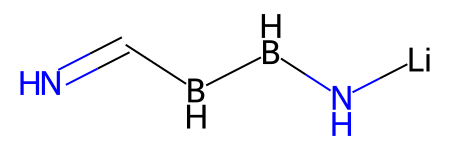

In [29]:
Chem.MolFromSmiles("[Li]NBBC=N")

## Brief Result Analysis

In [30]:
from rdkit import DataStructs

With the rdkit function of comparing similarities, here we'll demonstrate a preliminary analysis of the molecule we've generated. With "CCO" molecule as a control, we could observe that the new molecule we've generated is more similar to a random selected molecule(the fourth molecule) from the initial training set.

This may indicate that our model has indeed extracted some features from our original dataset and generated a new molecule that is relevant.

In [40]:
DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles("[Li]NBBC=N")), Chem.RDKFingerprint(Chem.MolFromSmiles("CCO")))# compare with the control

0.0

In [38]:
#compare with one from the original data
DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles("[Li]NBBC=N")), Chem.RDKFingerprint(Chem.MolFromSmiles("CCN1C2=NC(=O)N(C(=O)C2=NC(=N1)C3=CC=CC=C3)C")))

0.017079419299743808